In [ ]:
import os

os.mkdir("/content/ECE570")

In [ ]:
!wget -P /content/ECE570/ http://images.cocodataset.org/zips/train2017.zip

--2024-12-06 02:49:48--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.21.197, 54.231.160.49, 52.217.117.193, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.21.197|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘/content/ECE570/train2017.zip’

train2017.zip       100%[===================>]  18.01G  46.8MB/s    in 6m 56s  

2024-12-06 02:56:45 (44.3 MB/s) - ‘/content/ECE570/train2017.zip’ saved [19336861798/19336861798]



In [ ]:
!unzip /content/ECE570/train2017.zip -d /content/ECE570/

Streaming output truncated to the last 5000 lines.
 extracting: /content/ECE570/train2017/000000259556.jpg  
 extracting: /content/ECE570/train2017/000000381931.jpg  
 extracting: /content/ECE570/train2017/000000569592.jpg  
 extracting: /content/ECE570/train2017/000000229396.jpg  
 extracting: /content/ECE570/train2017/000000488990.jpg  
 extracting: /content/ECE570/train2017/000000348684.jpg  
 extracting: /content/ECE570/train2017/000000234031.jpg  
 extracting: /content/ECE570/train2017/000000563584.jpg  
 extracting: /content/ECE570/train2017/000000276069.jpg  
 extracting: /content/ECE570/train2017/000000401194.jpg  
 extracting: /content/ECE570/train2017/000000502089.jpg  
 extracting: /content/ECE570/train2017/000000192183.jpg  
 extracting: /content/ECE570/train2017/000000425127.jpg  
 extracting: /content/ECE570/train2017/000000126766.jpg  
 extracting: /content/ECE570/train2017/000000324161.jpg  
 extracting: /content/ECE570/train2017/000000452746.jpg  
 extracting: /content

In [ ]:
!wget -P /content/ECE570/ http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2024-12-06 02:58:51--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.30.23, 3.5.29.185, 52.216.63.73, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.30.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘/content/ECE570/annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  61.3MB/s    in 4.4s    

2024-12-06 02:58:56 (54.9 MB/s) - ‘/content/ECE570/annotations_trainval2017.zip’ saved [252907541/252907541]



In [ ]:
!unzip /content/ECE570/annotations_trainval2017.zip -d /content/ECE570/

Archive:  /content/ECE570/annotations_trainval2017.zip
  inflating: /content/ECE570/annotations/instances_train2017.json  
  inflating: /content/ECE570/annotations/instances_val2017.json  
  inflating: /content/ECE570/annotations/captions_train2017.json  
  inflating: /content/ECE570/annotations/captions_val2017.json  
  inflating: /content/ECE570/annotations/person_keypoints_train2017.json  
  inflating: /content/ECE570/annotations/person_keypoints_val2017.json  


In [ ]:


#Checking if the files were downloaded and stored properly

# Get the current working directory
current_working_directory = '/content/ECE570/train2017'

# Get a list of all directories in the current working directory
directories = [d for d in os.listdir(current_working_directory) if os.path.isdir(os.path.join(current_working_directory, d))]

# Print the list of directories
for directory in directories:
    print(directory)


In [ ]:
#@title Imports

import tensorflow.compat.v2 as tf
import importlib
import os.path as osp
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from PIL import Image
from pycocotools.coco import COCO
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import torchvision.transforms as tvt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
# @title NAM Source Code
# coding=utf-8
# Copyright 2020 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as: python3
"""Neural net models for tabular datasets."""

from typing import Union, List
import numpy as np
import tensorflow as tf

TfInput = Union[np.ndarray, tf.Tensor]


def exu(x, weight, bias):
  """ExU hidden unit modification."""
  return tf.exp(weight) * (x - bias)


# Activation Functions
def relu(x, weight, bias):
  """ReLU activation."""
  return tf.nn.relu(weight * (x - bias))


def relu_n(x, n = 1):
  """ReLU activation clipped at n."""
  return tf.clip_by_value(x, 0, n)

tf.device('/GPU:0')
class ActivationLayer(tf.keras.layers.Layer):
  """Custom activation Layer to support ExU hidden units."""

  def __init__(self,
               num_units,
               name = None,
               activation = 'exu',
               trainable = True):
    """Initializes ActivationLayer hyperparameters.

    Args:
      num_units: Number of hidden units in the layer.
      name: The name of the layer.
      activation: Activation to use. The default value of `None` corresponds to
        using the ReLU-1 activation with ExU units while `relu` would use
        standard hidden units with ReLU activation.
      trainable: Whether the layer parameters are trainable or not.
    """
    super(ActivationLayer, self).__init__(trainable=trainable, name=name)
    self.num_units = num_units
    self._trainable = trainable
    if activation == 'relu':
      self._activation = relu
      self._beta_initializer = 'glorot_uniform'
    elif activation == 'exu':
      self._activation = lambda x, weight, bias: relu_n(exu(x, weight, bias))
      self._beta_initializer = tf.initializers.truncated_normal(
          mean=4.0, stddev=0.5)
    else:
      raise ValueError('{} is not a valid activation'.format(activation))

  def build(self, input_shape):
    """Builds the layer weight and bias parameters."""
    self._beta = self.add_weight(
        name='beta',
        shape=[input_shape[-1], self.num_units],
        initializer=self._beta_initializer,
        trainable=self._trainable)
    self._c = self.add_weight(
        name='c',
        shape=[1, self.num_units],
        initializer=tf.initializers.truncated_normal(stddev=0.5),
        trainable=self._trainable)
    super(ActivationLayer, self).build(input_shape)

  @tf.function
  def call(self, x):
    """Computes the output activations."""
    center = tf.tile(self._c, [tf.shape(x)[0], 1])
    out = self._activation(x, self._beta, center)
    return out

tf.device('/GPU:0')
class FeatureNN(tf.keras.layers.Layer):
  """Neural Network model for each individual feature.

  Attributes:
    hidden_layers: A list containing hidden layers. The first layer is an
      `ActivationLayer` containing `num_units` neurons with specified
      `activation`. If `shallow` is False, then it additionally contains 2
      tf.keras.layers.Dense ReLU layers with 64, 32 hidden units respectively.
    linear: Fully connected layer.
  """

  def __init__(self,
               num_units,
               dropout = 0.5,
               trainable = True,
               shallow = True,
               feature_num = 0,
               name_scope = 'model',
               activation = 'exu'):
    """Initializes FeatureNN hyperparameters.

    Args:
      num_units: Number of hidden units in first hidden layer.
      dropout: Coefficient for dropout regularization.
      trainable: Whether the FeatureNN parameters are trainable or not.
      shallow: If True, then a shallow network with a single hidden layer is
        created, otherwise, a network with 3 hidden layers is created.
      feature_num: Feature Index used for naming the hidden layers.
      name_scope: TF name scope str for the model.
      activation: Activation and type of hidden unit(ExUs/Standard) used in the
        first hidden layer.
    """
    super(FeatureNN, self).__init__()
    self._num_units = num_units
    self._dropout = dropout
    self._trainable = trainable
    self._tf_name_scope = name_scope
    self._feature_num = feature_num
    self._shallow = shallow
    self._activation = activation

  def build(self, input_shape):
    """Builds the feature net layers."""
    self.hidden_layers = [
        ActivationLayer(
            self._num_units,
            trainable=self._trainable,
            activation=self._activation,
            name='activation_layer_{}'.format(self._feature_num))
    ]
    if not self._shallow:
      self._h1 = tf.keras.layers.Dense(
          64,
          activation='relu',
          use_bias=True,
          trainable=self._trainable,
          name='h1_{}'.format(self._feature_num),
          kernel_initializer='glorot_uniform')
      self._h2 = tf.keras.layers.Dense(
          32,
          activation='relu',
          use_bias=True,
          trainable=self._trainable,
          name='h2_{}'.format(self._feature_num),
          kernel_initializer='glorot_uniform')
      self.hidden_layers += [self._h1, self._h2]
    self.linear = tf.keras.layers.Dense(
        1,
        use_bias=False,
        trainable=self._trainable,
        name='dense_{}'.format(self._feature_num),
        kernel_initializer='glorot_uniform')
    super(FeatureNN, self).build(input_shape)

  @tf.function(reduce_retracing=True)
  def call(self, x, training):
    """Computes FeatureNN output with either evaluation or training mode."""
    with tf.name_scope(self._tf_name_scope):
      for l in self.hidden_layers:
        x = tf.nn.dropout(
            l(x), rate=tf.cond(training, lambda: self._dropout, lambda: 0.0))
      x = tf.squeeze(self.linear(x), axis=1)
    return x

class NAM(tf.keras.Model):
  """Neural additive model.

  Attributes:
    feature_nns: List of FeatureNN, one per input feature.
  """

  def __init__(self,
               num_inputs,
               num_units,
               trainable = True,
               shallow = True,
               feature_dropout = 0.0,
               dropout = 0.0,
               **kwargs):
    """Initializes NAM hyperparameters.

    Args:
      num_inputs: Number of feature inputs in input data.
      num_units: Number of hidden units in first layer of each feature net.
      trainable: Whether the NAM parameters are trainable or not.
      shallow: If True, then shallow feature nets with a single hidden layer are
        created, otherwise, feature nets with 3 hidden layers are created.
      feature_dropout: Coefficient for dropping out entire Feature NNs.
      dropout: Coefficient for dropout within each Feature NNs.
      **kwargs: Arbitrary keyword arguments. Used for passing the `activation`
        function as well as the `name_scope`.
    """
    super(NAM, self).__init__()
    self._num_inputs = num_inputs
    if isinstance(num_units, list):
      assert len(num_units) == num_inputs
      self._num_units = num_units
    elif isinstance(num_units, int):
      self._num_units = [num_units for _ in range(self._num_inputs)]
    self._trainable = trainable
    self._shallow = shallow
    self._feature_dropout = feature_dropout
    self._dropout = dropout
    self._kwargs = kwargs

  def build(self, input_shape):
    """Builds the FeatureNNs on the first call."""
    self.feature_nns = [None] * self._num_inputs
    #print(self._num_inputs)
    #print(input_shape)
    for i in range(self._num_inputs):
      self.feature_nns[i] = FeatureNN(
          num_units=self._num_units[i],
          dropout=self._dropout,
          trainable=self._trainable,
          shallow=self._shallow,
          feature_num=i,
          **self._kwargs)
    self._bias = self.add_weight(
        name='bias',
        initializer=tf.keras.initializers.Zeros(),
        shape=(1,),
        trainable=self._trainable)
    self._true = tf.constant(True, dtype=tf.bool)
    self._false = tf.constant(False, dtype=tf.bool)
    for i in range(self._num_inputs):
      setattr(self, f'feature_nn_(i)', self.feature_nns[i])

  def call(self, x, training = True):
    """Computes NAM output by adding the outputs of individual feature nets."""
    #print("Input shape:", tf.shape(x))
    individual_outputs = self.calc_outputs(x, training=training)
    stacked_out = tf.stack(individual_outputs, axis=-1)
    training = self._true if training else self._false
    dropout_out = tf.nn.dropout(
        stacked_out,
        rate=tf.cond(training, lambda: self._feature_dropout, lambda: 0.0))
    out = tf.reduce_sum(dropout_out, axis=-1)
    out = tf.sigmoid(out + self._bias) # Added this to focus for binary classification
    return out

  def _name_scope(self):
    """Overrides the default function to fix name_scope for bias."""
    tf_name_scope = self._kwargs.get('name_scope', None)
    name_scope = super(NAM, self)._name_scope()
    if tf_name_scope:
      return tf_name_scope + '/' + name_scope
    else:
      return name_scope

  def calc_outputs(self, x, training = True):
    """Returns the output computed by each feature net."""
    training = self._true if training else self._false
    list_x = tf.split(x, self._num_inputs, axis=-1)
    return [
        self.feature_nns[i](x_i, training=training)
        for i, x_i in enumerate(list_x)
    ]


class DNN(tf.keras.Model):
  """Deep Neural Network with 10 hidden layers.

  Attributes:
    hidden_layers: A list of 10 tf.keras.layers.Dense layers with ReLU.
    linear: Fully-connected layer.
  """

  def __init__(self, trainable = True, dropout = 0.15):
    """Creates the DNN layers.

    Args:
      trainable: Whether the DNN parameters are trainable or not.
      dropout: Coefficient for dropout regularization.
    """
    super(DNN, self).__init__()
    self._dropout = dropout
    self.hidden_layers = [None for _ in range(10)]
    for i in range(10):
      self.hidden_layers[i] = tf.keras.layers.Dense(
          100,
          activation='relu',
          use_bias=True,
          trainable=trainable,
          name='dense_{}'.format(i),
          kernel_initializer='he_normal')
    self.linear = tf.keras.layers.Dense(
        1,
        use_bias=True,
        trainable=trainable,
        name='linear',
        kernel_initializer='he_normal')
    self._true = tf.constant(True, dtype=tf.bool)
    self._false = tf.constant(False, dtype=tf.bool)

  def call(self, x, training = True):
    """Creates the output tensor given an input."""
    training = self._true if training else self._false
    for l in self.hidden_layers:
      x = tf.nn.dropout(
          l(x), rate=tf.cond(training, lambda: self._dropout, lambda: 0.0))
    x = tf.squeeze(self.linear(x), axis=-1)
    return x


In [ ]:
def create_nam_model(x_train,
                     dropout,
                     feature_dropout = 0.0,
                     num_basis_functions = 1000,
                     units_multiplier = 2,
                     activation = 'exu',
                     name_scope = 'model',
                     shallow = True,
                     trainable = True):
  """Create the NAM model."""
  num_unique_vals = [
      len(np.unique(x_train[:, i])) for i in range(x_train.shape[1])
  ]
  num_units = [
      min(num_basis_functions, i * units_multiplier) for i in num_unique_vals
  ]
  num_inputs = x_train.shape[-1]
  nn_model = NAM(
      num_inputs=num_inputs,
      num_units=num_units,
      dropout=np.float32(dropout),
      feature_dropout=np.float32(feature_dropout),
      activation=activation,
      shallow=shallow,
      trainable=trainable,
      name_scope=name_scope)
  return nn_model


In [ ]:
# Specify the path to the annotations file
ann_file = "/content/ECE570/annotations/instances_train2017.json"
#I initially wanted to do both validation and training annotations, but it is not possible in this scenario, as the validation set was only around 150

# Load the annotations
coco = COCO(ann_file)

loading annotations into memory...
Done (t=16.67s)
creating index...
index created!


In [ ]:
# Taken inspiration from Solution 2 of Spring 2023

classes =  ['person', 'bicycle', 'car', 'bus', 'motorcycle']

person_id = coco.getCatIds(catNms = 'person')
bicycle_id = coco.getCatIds(catNms = 'bicycle')
catIds = [person_id[0], bicycle_id[0]] #get all the class indices for the different categories
print(catIds)
train_data = dict(zip(classes, [[] for i in range(len(classes))])) #Create a dictionary such that the class name is a key with an empty list to contain the image names
val_data = dict(zip(classes, [[] for i in range(len(classes))])) #Create a dictionary such that the class name is a key with an empty list to contain the image names

if not os.path.exists("train_data"):
  os.mkdir("train_data")
if not os.path.exists("val_data"):
  os.mkdir("val_data")


[1, 2]


In [ ]:
for i, idx in enumerate(catIds):
  imgIds = coco.getImgIds(catIds=idx) #Get all the image ids for a classes[i]
  imgIds = list(np.random.choice(imgIds, size=50, replace=False)) #Randomely choose 2000 of the images as training data set
  #print("categor is ", classes[i], "with category id", catIds[i])
  for counter, img_idx in enumerate(imgIds): #Going through the whole list of image ids to store it as the dataset
    file_name = coco.loadImgs(int(img_idx))[0]['file_name'] #get the file name of the image from the list gotten before
    img_path = os.path.join(current_working_directory, f"{file_name}")
    img = Image.open(img_path).convert("RGB")
    img = img.resize((64, 64)) # resize

    class_name = classes[i]
    save_name = class_name + "_" + file_name #writing the file name to be more readable and inorder to get class names easier when creating the data set

    if counter < 40:
      save_dir = "train_data"
      train_data[class_name].append(save_name)
    else:
      save_dir = "val_data"
      val_data[class_name].append(save_name)
    img.save(os.path.join(save_dir, save_name)) #Saving the image in the proper directory with the readable file name

In [ ]:
def plot_images(train_data):
  # class names
  classes = ['person', 'bicycle']
  # plot random 5 images for each class
  fig, axs = plt.subplots(2, 5)
  fig.tight_layout()
  for i, cat in enumerate(classes):
    files = train_data[cat]
    chosen = random.sample(files, 5)
    # sample 5 random images
    for  j, file_name in enumerate(chosen):
      img = Image.open(os.path.join('train_data', file_name)) # load image
      axs[i, j].imshow(img) # plot image
      axs[i, j].axis('off')
      axs[i, j].set_title(f"{cat} {j + 1}", size=7)
  plt.show()

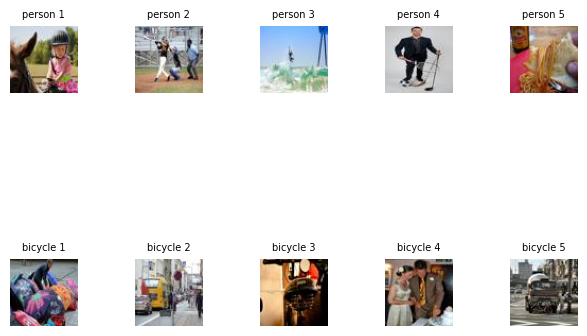

In [ ]:
plot_images(train_data)

In [ ]:
def preprocess_data(data_dict, val = False):
    classes = list(data_dict.keys())  # Get the class names
    base_model = VGG16(weights='imagenet', include_top=False)
    layer_name = 'block5_pool'
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

    # Create a list of (image_path, label) tuples
    image_paths = []
    labels = []
    for class_name, images in data_dict.items():
        for image_path in images:
            if val:
              image_paths.append(os.path.join('val_data', image_path))
            else:
              image_paths.append(os.path.join('train_data', image_path))
            # Binary label assignment:
            labels.append(1 if class_name == 'person' else 0)

    # Create a tf.data.Dataset from the image paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Define the preprocessing function
    def preprocess_image(image_path, label):
        image_raw = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.image.resize(image, [224, 224])  # Match VGG16 input size
        image = tf.keras.applications.vgg16.preprocess_input(image)  # Preprocess for VGG16
        return image, label

    # Apply preprocessing and feature extraction
    def extract_features(image, label):
        # Extract features using the pre-trained model
        features = feature_extractor(image[tf.newaxis, ...])  # Add batch dimension
        features = tf.reduce_mean(features, axis=(1, 2))  # Global average pooling over spatial dimensions
        features = tf.reshape(features, [-1])  # Flatten into 1D vector
        features_min = tf.reduce_min(features)
        features_max = tf.reduce_max(features)
        normalized_features = (features - features_min) / (features_max - features_min + 1e-8)

        return normalized_features, label

    # Build the dataset pipeline
    dataset = (
        dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .map(extract_features, num_parallel_calls=tf.data.AUTOTUNE)
        .shuffle(buffer_size=len(image_paths))
        .batch(32)  # Batch size for efficient processing
        .prefetch(tf.data.AUTOTUNE)
    )

    # Accumulate features and labels
    all_features = []
    all_labels = []
    for features, label in dataset:
        all_features.append(features)
        all_labels.append(label)

    # Convert to tensors
    x_train = tf.concat(all_features, axis=0)  # Concatenate all feature batches
    y_train = tf.concat(all_labels, axis=0)

    return x_train, y_train

In [ ]:
x_train, y_train = preprocess_data(train_data)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(y_train)

(80, 512)
(80,)
tf.Tensor(
[1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1 0 0
 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1
 0 0 1 0 1 1], shape=(80,), dtype=int32)


In [ ]:
#@title Create NAM model
with tf.device('/GPU:0'):
  tf.compat.v1.reset_default_graph()
  nn_model = create_nam_model(
      x_train=x_train,
      dropout=0.5,
      num_basis_functions=1,
      activation='relu',
      trainable=True,
      shallow=True,
      name_scope='model_0')


In [ ]:
with tf.device('/GPU:0'):
  output = nn_model(x_train[:1])
  print(output)
  nn_model.summary()

tf.Tensor([0.9987413], shape=(1,), dtype=float32)


Model: "nam"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_nn (FeatureNN)               │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_1 (FeatureNN)             │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_2 (FeatureNN)             │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_3 (FeatureNN)             │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_4 (FeatureNN)             │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_5 (FeatureNN)             │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_6 (FeatureNN)             │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_7 (FeatureNN)             │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_8 (FeatureNN)             │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_9 (FeatureNN)             │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_10 (FeatureNN)            │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_11 (FeatureNN)            │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_12 (FeatureNN)            │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_13 (FeatureNN)            │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_14 (FeatureNN)            │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_15 (FeatureNN)            │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_16 (FeatureNN)            │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_17 (FeatureNN)            │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_18 (FeatureNN)            │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_19 (FeatureNN)            │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_nn_20 (FeatureNN)            │ ?                           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,537 (6.00 KB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the NAM Model with interminient checking for accuracy
with tf.device('/GPU:0'):
  from tensorflow.keras.callbacks import EarlyStopping
  early_stopping = EarlyStopping(
      monitor='accuracy',  # Or 'val_accuracy' depending on your metric
      patience=5,  # Number of epochs to wait for improvement
      restore_best_weights=True
  )

  nn_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss='binary_crossentropy',
      metrics=['accuracy']
  )


  history = nn_model.fit(
      x_train,
      y_train,
      epochs=20,
      batch_size=20,
      callbacks=[early_stopping]
  )

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
def preprocess_data_CNN(data_dict, val = False):
    classes = list(data_dict.keys())  # Get the class names

    # Create a list of (image_path, label) tuples
    image_paths = []
    labels = []
    for class_name, images in data_dict.items():
        for image_path in images:
            if val:
              image_paths.append(os.path.join('val_data', image_path))
            else:
              image_paths.append(os.path.join('train_data', image_path))
            # Binary label assignment:
            labels.append(1 if class_name == 'person' else 0)

    # Create a tf.data.Dataset from the image paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Define the preprocessing function
    def preprocess_image(image_path, label):
        image_raw = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image_raw, channels=3)  # Decode JPEG images
        image = tf.image.resize(image, [224, 224])  # Resize images to match input size
        image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
        return image, label

    # Build the dataset pipeline
    dataset = (
        dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .shuffle(buffer_size=len(image_paths))
        .batch(20)  # Batch size for efficient processing
        .prefetch(tf.data.AUTOTUNE)  # Prefetch to overlap data preprocessing and model execution
    )

    return dataset


In [ ]:
dataset_train = preprocess_data_CNN(train_data)
dataset_val = preprocess_data_CNN(val_data)
x_train, y_train = next(iter(dataset_train))
x_val, y_val = next(iter(dataset_train))
print(x_val.shape)
print(y_val.shape)

(20, 224, 224, 3)
(20,)


In [ ]:
# Initialize CNN network via Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam


model = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 197136)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │       6,308,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,308,865 (24.07 MB)

 Trainable params: 6,308,865 (24.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
#Train the CNN Model
history = model.fit(dataset_train, epochs=20, verbose=1)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5067 - loss: 6.7366
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4833 - loss: 1.1775
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5517 - loss: 0.9787
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5483 - loss: 0.8045
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5967 - loss: 0.6489
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6550 - loss: 0.6453
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4933 - loss: 0.6658
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4933 - loss: 0.6538
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5567 - loss: 0.6581
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5633 - loss: 0.6337
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6000 - loss: 0.6003
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5733 - loss: 0.5686
E

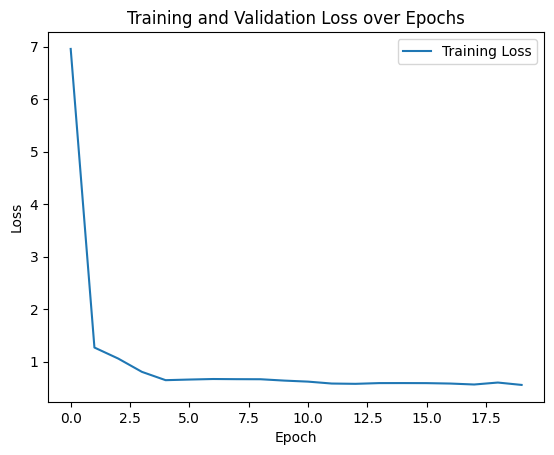

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
!pip freeze > requirements.txt

In [ ]:
!cat requirements.txt